# 1. Load Data & Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [5]:
transcript['viewed_id'] =  transcript.apply(lambda x:x['value']['offer id'] if x['event']=='offer viewed' else np.nan,axis=1)

In [6]:
transcript['amount'] =  transcript.apply(lambda x:x['value']['amount'] if x['event']=='transaction' else np.nan,axis=1)

In [7]:
transcript['received_id'] = transcript.apply(lambda x:x['value']['offer id'] if x['event']=='offer received' else np.nan,axis=1)

In [8]:
transcript['completed_id'] = transcript.apply(lambda x:x['value']['offer_id'] if x['event']=='offer completed' else np.nan,axis=1)

In [9]:
transcript.head()

,person,event,value,time,viewed_id,amount,received_id,completed_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [76]:
 def clean_transcript(df):
    people_list = df.person.drop_duplicates().tolist()
    result = pd.DataFrame(columns=['person','offer_completed','id','amount'])
    
    for person in people_list:
        person_data = df[df.person == person]
        received_df = person_data[~person_data.received_id.isna()]
        completed_df = person_data[~person_data.completed_id.isna()]
        offer_ids = received_df.received_id.drop_duplicates().tolist()
        completed_ids = completed_df.completed_id.drop_duplicates().tolist()
        transaction_df = person_data[person_data.event=='transaction']
        for offer in offer_ids:
            if offer in completed_ids:
                offer_completed=1
                time = completed_df[completed_df.completed_id == offer]['time'].values[0]
                amount = transaction_df[transaction_df.time==time]['amount'].max()
            else:
                offer_completed = 0
                amount = np.nan
            temp_df = pd.DataFrame({'person':person,'offer_completed':offer_completed,'id':offer,'amount':amount},index=[0])
            result = result.append(temp_df,ignore_index=True)
        # calculate the rate of transaction with "none" offer
        #transaction_df = person_data[person_data.event=='transaction']
        transaction_time = transaction_df.time.tolist()
        #transaction_with_offer = 0
        for tran_time in transaction_time:
            time_df = person_data[person_data.time == tran_time]
            event =  time_df.event.tolist()
            if 'offer completed' not in event:
                transaction_with_offer = 1
                amount = transaction_df[transaction_df.time==tran_time].amount.max()
                temp_df = pd.DataFrame({'person':person,'offer_completed':transaction_with_offer,'id':'none','amount':amount},index=[0])
                result = result.append(temp_df,ignore_index=True)
        
    return result
            
                
    
    

In [77]:
transcript.person.drop_duplicates()

0         78afa995795e4d85b5d9ceeca43f5fef
1         a03223e636434f42ac4c3df47e8bac43
2         e2127556f4f64592b11af22de27a7932
3         8ec6ce2a7e7949b1bf142def7d0e0586
4         68617ca6246f4fbc85e91a2a49552598
                        ...               
213585    9fcbff4f8d7241faa4ab8a9d19c8a812
222411    ebae5093b436466c9fbd097cb7434023
249251    912b9f623b9e4b4eb99b6dc919f09a93
253904    3045af4e98794a04a5542d3eac939b1f
263150    da7a7c0dcfcb41a8acc7864a53cf60fb
Name: person, Length: 17000, dtype: object

In [79]:
clean_transcript(transcript)

,person,offer_completed,id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89
1,78afa995795e4d85b5d9ceeca43f5fef,0,5a8bc65990b245e5a138643cd4eb9837,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,1,ae264e3637204a6fb9bb56bc8210ddfd,21.72
3,78afa995795e4d85b5d9ceeca43f5fef,1,f19421c1d4aa40978ebb69ca19b0e20d,21.72
4,78afa995795e4d85b5d9ceeca43f5fef,1,none,17.78
5,78afa995795e4d85b5d9ceeca43f5fef,1,none,19.67
6,78afa995795e4d85b5d9ceeca43f5fef,1,none,29.72
7,78afa995795e4d85b5d9ceeca43f5fef,1,none,23.93
8,78afa995795e4d85b5d9ceeca43f5fef,1,none,26.56
9,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [80]:
cleaned_data = _

In [12]:
cleaned_data.head()

,person,offer_completed,id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89
1,78afa995795e4d85b5d9ceeca43f5fef,0,5a8bc65990b245e5a138643cd4eb9837,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,1,ae264e3637204a6fb9bb56bc8210ddfd,21.72
3,78afa995795e4d85b5d9ceeca43f5fef,1,f19421c1d4aa40978ebb69ca19b0e20d,21.72
4,78afa995795e4d85b5d9ceeca43f5fef,1,none,17.78


In [13]:
profile = profile.rename(columns={'id':'person'})

In [14]:
cleaned_data.head()

,person,offer_completed,id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89
1,78afa995795e4d85b5d9ceeca43f5fef,0,5a8bc65990b245e5a138643cd4eb9837,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,1,ae264e3637204a6fb9bb56bc8210ddfd,21.72
3,78afa995795e4d85b5d9ceeca43f5fef,1,f19421c1d4aa40978ebb69ca19b0e20d,21.72
4,78afa995795e4d85b5d9ceeca43f5fef,1,none,17.78


In [15]:
data = pd.merge(cleaned_data,profile,how='inner',on='person')

In [16]:
data.shape

(171624, 8)

In [17]:
data = pd.merge(data,portfolio,how='outer',on='id')

In [18]:
data['offer_type'] = data.offer_type.fillna('none')

In [19]:
data[data.id=='none']

,person,offer_completed,id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
25311,78afa995795e4d85b5d9ceeca43f5fef,1,none,17.78,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,none
25312,78afa995795e4d85b5d9ceeca43f5fef,1,none,19.67,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,none
25313,78afa995795e4d85b5d9ceeca43f5fef,1,none,29.72,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,none
25314,78afa995795e4d85b5d9ceeca43f5fef,1,none,23.93,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,none
25315,78afa995795e4d85b5d9ceeca43f5fef,1,none,26.56,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133642,3873fe915496482eb589fa316ae7b0db,1,none,1.21,M,58,20170905,57000.0,NaN,NaN,NaN,NaN,none
133643,3873fe915496482eb589fa316ae7b0db,1,none,2.65,M,58,20170905,57000.0,NaN,NaN,NaN,NaN,none
133644,8578196a074a4f328976e334fa9383a3,1,none,4.62,M,48,20180610,58000.0,NaN,NaN,NaN,NaN,none
133645,ebae5093b436466c9fbd097cb7434023,1,none,2.57,None,118,20171203,NaN,NaN,NaN,NaN,NaN,none


In [20]:
def transfer_channels(x,tag):
    if type(x)==list:
        if tag in x:
            return 1
        else:
            return 0
    else:
        return np.nan

In [21]:
# transfer channels into dummy variables
for tag in ['web', 'email', 'mobile', 'social']:
    data[tag] = data['channels'].apply(lambda x: transfer_channels(x,tag))

In [22]:
data.shape

(171624, 17)

# 2. Data Preprocessing & Model Tuning

## 2.1 Data Preprocessing

In [23]:
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
#from sklearn.
#from xgboost import XGBClassifier

In [24]:
import datetime
def calculate_time(x):
    try:
        x = str(int(x))
        x_ts = datetime.datetime.strptime(x,'%Y%m%d')
        time_delta = datetime.datetime.now()-x_ts
        return time_delta.days
    except:
        return np.nan

In [25]:
data['member_duration'] = data.became_member_on.apply(lambda x:calculate_time(x))

In [26]:
def transfer_gender_variables(x):
    if x=='F':
        return 1
    elif x =='M':
        return -1
    else:
        return 0
data['gender'] = data['gender'].apply(lambda x:transfer_gender_variables(x))

In [27]:
for col in ['reward','difficulty','duration','web','email','mobile','social','amount']:
    data[col] = data[col].fillna(0.0)

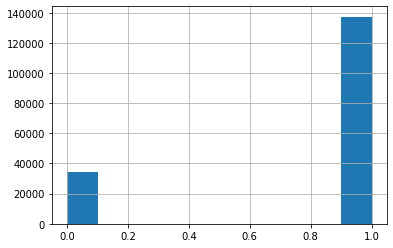

In [28]:
data.offer_completed.hist()

In [29]:
data_input = data.dropna(subset=[ 'gender',
       'age',  'member_duration', 'income','reward','duration','difficulty'])

In [30]:
del data_input['channels']

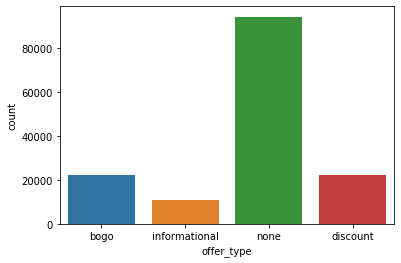

In [31]:
import seaborn as sns
sns.countplot(x='offer_type', data=data_input)

In [32]:
data_input.head()

,person,offer_completed,id,amount,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,web,email,mobile,social,member_duration
0,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89,1,75,20170509,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,1259
1,e2127556f4f64592b11af22de27a7932,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,18.42,-1,68,20180426,70000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,907
3,389bc3fa690240e798340f5a15918d5c,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,15.63,-1,65,20180209,53000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,983
4,d058f73bf8674a26a95227db098147b1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,1,56,20180428,88000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,905
6,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,-1,59,20150121,41000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,2098


## 2.2 Benchmark Model : Logistic Regression 

In [238]:
data_input = shuffle(data_input)

In [239]:
X_col = ['gender','age', 'member_duration', 'income','reward']

data_X = data_input.loc[:,X_col]
data_y = data_input.loc[:,'offer_completed']

In [240]:
normalized_x = normalize(data_X)

In [241]:
x_train, x_test, y_train, y_test = train_test_split(normalized_x, data_y.values, test_size=0.25, random_state=1)

In [242]:
x_train.shape

(112198, 5)

In [243]:
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [244]:
logistic_regression_model.score(x_train,y_train)

0.817688372341753

In [245]:
train_y_predicted = logistic_regression_model.predict(x_train)

In [246]:
from sklearn.metrics import f1_score

In [247]:
f1_score(y_train,train_y_predicted)

0.8997013842238687

In [248]:
logistic_regression_model.score(x_test,y_test)

0.8175133689839572

In [249]:
test_y_predicted = logistic_regression_model.predict(x_test)

In [250]:
f1_score(y_test,test_y_predicted)

0.8995954394998161

## 2.3 Random Forest

In [260]:
data_input = shuffle(data_input)
data_X = data_input.loc[:,[ 'gender','age', 'member_duration', 
                           'income','reward','difficulty']]
data_y = data_input.loc[:,'offer_completed']
normalized_x = normalize(data_X)
x_train, x_test, y_train, y_test = train_test_split(normalized_x, data_y.values, test_size=0.25, random_state=1)

In [261]:
decision_tree_model = DecisionTreeClassifier(random_state=0)
decision_tree_model.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [262]:
decision_tree_model.score(x_train,y_train)

0.9252927859676643

In [263]:
train_y_predicted = decision_tree_model.predict(x_train)
f1_score(y_train,train_y_predicted)

0.955496325871809

In [276]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [277]:
random_forest_model.score(x_train,y_train)

0.9252927859676643

In [278]:
train_y_predicted = random_forest_model.predict(x_train)

In [279]:
f1_score(y_train,train_y_predicted)

0.9560300057703405

In [294]:
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [296]:
adaboost_model.score(x_train,y_train)

0.8351307509937789

In [298]:
train_y_predicted = adaboost_model.predict(x_train)

In [299]:
f1_score(y_train,train_y_predicted)

0.9059181348415184

## XGBosst Model

In [301]:
import xgboost

ModuleNotFoundError: No module named 'xgboost'